In [1]:
import os, sys

codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from plotting import plot_utils, load_fits
from utils import roi_utils, default_paths
from feature_extraction import gabor_feature_extractor


#### Load fit results

In [3]:
subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type1 = 'gabor_solo_ridge_12ori_8sf'
out1 = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type1, n_from_end=0, \
                                  verbose=False) for ss in subjects]
fitting_type2 = 'gabor_solo_ridge_12ori_8sf_from_residuals'
out2 = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type2, n_from_end=0, \
                                  verbose=False) \
       for ss in subjects]

# create non-overlapping ROIs
roi_def = roi_utils.multi_subject_roi_def(subjects, remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = len(roi_names)

# make a list of voxels per subject
n_vox_each_subj = [out1[si]['best_params'][0].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones((n_vox_each_subj[si],),dtype=int) \
                               for si in range(n_subjects)], axis=0)

#### Threshold voxels by R2
make sure it is always the same set of voxels when comparing across models. 
have to pass threshold for both.

In [4]:
r2_cutoff = 0.01
val_r2_1 = np.concatenate([out1[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
val_r2_2 = np.concatenate([out2[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = (val_r2_1>r2_cutoff) & (val_r2_2>r2_cutoff)

#### Get info about the Gabor feature space

In [5]:
n_sf=8; n_ori=12;
_gabor_ext_complex = gabor_feature_extractor.gabor_extractor_multi_scale(n_ori=n_ori, n_sf=n_sf)

screen_eccen_deg=8.4
sf_cyc_per_stim = _gabor_ext_complex.feature_table['SF: cycles per stim']
sf_cyc_per_deg = sf_cyc_per_stim/screen_eccen_deg
sf_unique, sf_inds = np.unique(sf_cyc_per_deg, return_inverse=True)

ori_deg = _gabor_ext_complex.feature_table['Orientation: degrees']
ori_unique, orient_inds = np.unique(ori_deg, return_inverse=True)


#### Organize the feature sensitivity matrices
feature sensitivity = corr coef between model resp and feature channel activation

In [6]:
feature_corr1 = np.concatenate([out1[si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr1.shape[0]
allcorr_reshaped1 = np.reshape(feature_corr1, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr1 = np.mean(allcorr_reshaped1, axis=2)
mean_sf_corr1 = np.mean(allcorr_reshaped1, axis=1)

# find maxes across orient/SF.
preferred_ori_corr1 = np.argmax(mean_orient_corr1, axis=1).astype(np.float32)
is_constant1 = np.all(np.tile(mean_orient_corr1[:,0:1], [1,n_ori])==mean_orient_corr1, axis=1)
assert(not(np.any(is_constant1)))

preferred_sf_corr1 = np.argmax(mean_sf_corr1, axis=1).astype(np.float32)
is_constant1 = np.all(np.tile(mean_sf_corr1[:,0:1], [1,n_sf])==mean_sf_corr1, axis=1)
assert(not(np.any(is_constant1)))

feature_corr2 = np.concatenate([out2[si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr2.shape[0]
allcorr_reshaped2 = np.reshape(feature_corr2, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr2 = np.mean(allcorr_reshaped2, axis=2)
mean_sf_corr2 = np.mean(allcorr_reshaped2, axis=1)

preferred_ori_corr2 = np.argmax(mean_orient_corr2, axis=1).astype(np.float32)
is_constant2 = np.all(np.tile(mean_orient_corr2[:,0:1], [1,n_ori])==mean_orient_corr2, axis=1)
assert(not(np.any(is_constant2)))

preferred_sf_corr2 = np.argmax(mean_sf_corr2, axis=1).astype(np.float32)
is_constant2 = np.all(np.tile(mean_sf_corr2[:,0:1], [1,n_sf])==mean_sf_corr2, axis=1)
assert(not(np.any(is_constant2)))


#### for each voxel, how correlated are the estimates of its tuning from two methods?

In [7]:
corr_between_methods = np.array([np.corrcoef(feature_corr1[vv,:], feature_corr2[vv,:])[0,1] \
                                 for vv in range(n_voxels)])

avg_corr_bw_methods = np.zeros((n_rois, n_subjects))
for rr in range(n_rois):
    for ss in range(n_subjects):
        inds_this_roi = roi_def.get_indices(rr) & abv_thresh & (subject_inds==ss)
        avg_corr_bw_methods[rr,ss] = np.mean(corr_between_methods[inds_this_roi])

#### Summary plot of these correlations

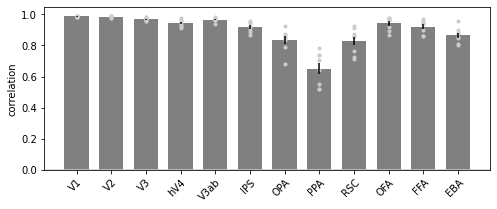

In [8]:
mean_vals = np.mean(avg_corr_bw_methods, axis=1, keepdims=True)
sem_vals = np.std(avg_corr_bw_methods, axis=1, keepdims=True)/np.sqrt(n_subjects)

plt.rcParams['pdf.fonttype']=42
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                point_data=avg_corr_bw_methods.T[:,:,np.newaxis], 
                                space=0.15, \
                xticklabels=roi_names, ylabel='correlation', \
                ylim=[0.0, 1.05], title='',\
                fig_size=(8,3), \
                colors=np.array([[0.5, 0.5, 0.5]]))

fn2save = os.path.join(default_paths.fig_path, 'Similarity_featuretuning_raw_vs_resid.pdf')
plt.savefig(fn2save)

#### how much did performance drop when regressing out coco-all features?

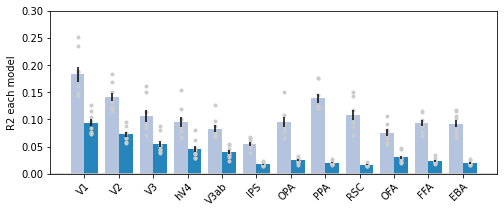

In [9]:
# note this is the average performance over voxels that already passed the threshold of R2. 
avg_r2 = np.zeros((n_subjects, n_rois, 2))
for rr in range(n_rois):
    for ss in range(n_subjects):
        inds_this_roi = roi_def.get_indices(rr) & abv_thresh & (subject_inds==ss)
        avg_r2[ss,rr,0] = np.mean(val_r2_1[inds_this_roi])
        avg_r2[ss,rr,1] = np.mean(val_r2_2[inds_this_roi])

mean_vals = np.mean(avg_r2, axis=0)
sem_vals = np.std(avg_r2, axis=0)/np.sqrt(n_subjects)

colors = cm.PuBu(np.linspace(0,1,4))[1:,:]
plt.rcParams['pdf.fonttype']=42
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                point_data=avg_r2, 
                                space=0.1, \
                xticklabels=roi_names, ylabel='R2 each model', \
                ylim=[0.0,0.3], title='',\
                colors=colors,\
                fig_size=(8,3))

fn2save = os.path.join(default_paths.fig_path, 'R2_compare_raw_vs_resid.pdf')
plt.savefig(fn2save)

### Violin plots - orientation sensitivity

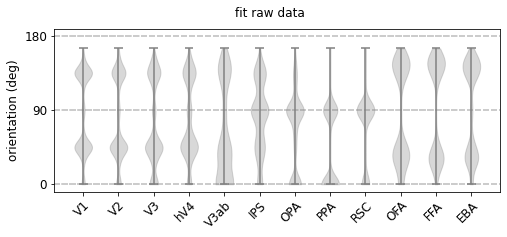

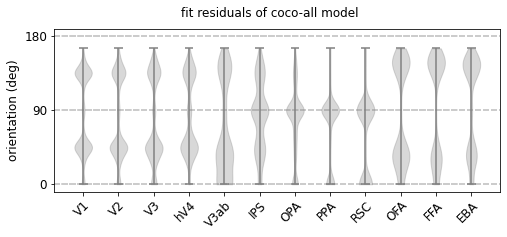

In [10]:
plot_utils.set_all_font_sizes(12)

plt.rcParams['pdf.fonttype']=42

color = '#7f7f7f'
          
names = ['fit raw data', 'fit residuals of coco-all model']

pi=0
for corrs, name in zip([preferred_ori_corr1, preferred_ori_corr2], names):

    plt.figure(figsize=(8,3))

    for ri in range(n_rois):
        
        inds_this_roi = roi_def.get_indices(ri) & abv_thresh

        parts = plt.violinplot(ori_unique[corrs[inds_this_roi].astype(int)],[ri])
        for pc in parts['bodies']:
            pc.set_color(color)
        parts['cbars'].set_color(color)
        parts['cmins'].set_color(color)
        parts['cmaxes'].set_color(color)

        plt.yticks([0,90,180])
        plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
        plt.axhline(90,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
        plt.axhline(180,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

        plt.ylabel('orientation (deg)')

        plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

    plt.xticks(ticks=np.arange(0,n_rois),labels=roi_names,\
                           rotation=45, ha='right',rotation_mode='anchor')

    plt.suptitle('%s'%name)


### Violin plots for a subset of ROIs only

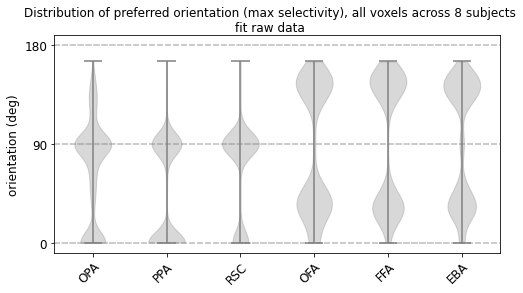

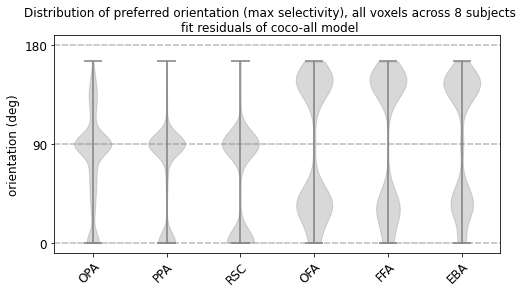

In [11]:
plot_utils.set_all_font_sizes(12)

plt.rcParams['pdf.fonttype']=42

color = '#7f7f7f'

names = ['fit raw data', 'fit residuals of coco-all model']

rois2plot = [6,7,8,9,10,11]

pi=0
for corrs, name in zip([preferred_ori_corr1, preferred_ori_corr2], names):

    plt.figure(figsize=(8,4))

    for ri, rr in enumerate(rois2plot):
        
        inds_this_roi = roi_def.get_indices(rr) & abv_thresh

        parts = plt.violinplot(ori_unique[corrs[inds_this_roi].astype(int)],[ri])
        for pc in parts['bodies']:
            pc.set_color(color)
        parts['cbars'].set_color(color)
        parts['cmins'].set_color(color)
        parts['cmaxes'].set_color(color)

        plt.yticks([0,90,180])
        plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
        plt.axhline(90,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
        plt.axhline(180,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

        plt.ylabel('orientation (deg)')

        plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

    plt.xticks(ticks=np.arange(0,len(rois2plot)),\
                           labels=np.array(roi_names)[rois2plot],\
                           rotation=45, ha='right',rotation_mode='anchor')

    plt.suptitle('Distribution of preferred orientation (max sensitivity), all voxels across 8 subjects\n%s'%name)

    pi+=1
    fn2save = os.path.join(default_paths.fig_path, 'Orient_violins_semresiduals_%d.pdf'%pi)
    plt.savefig(fn2save)

### Violin plots - frequency sensitivity

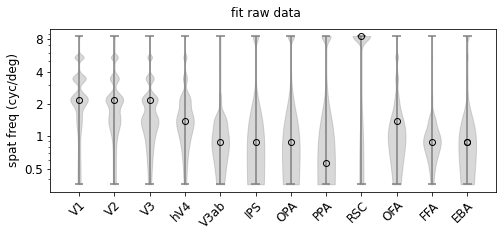

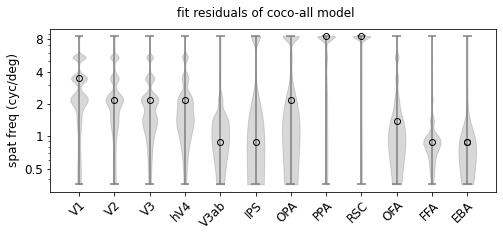

In [12]:

plot_utils.set_all_font_sizes(12)

plt.rcParams['pdf.fonttype']=42

color = '#7f7f7f'

names = ['fit raw data', 'fit residuals of coco-all model']

pi=0
for corrs, name in zip([preferred_sf_corr1, preferred_sf_corr2], names):

    plt.figure(figsize=(8,3))

    for ri in range(n_rois):

        inds_this_roi = roi_def.get_indices(ri) & abv_thresh

        parts = plt.violinplot(sf_unique[corrs[inds_this_roi].astype(int)],[ri])
        for pc in parts['bodies']:
            pc.set_color(color)
        parts['cbars'].set_color(color)
        parts['cmins'].set_color(color)
        parts['cmaxes'].set_color(color)
        
        plt.plot(ri, np.median(sf_unique[corrs[inds_this_roi].astype(int)]),\
             marker='o',color='k', markerfacecolor='none')

    plt.plot(ri, np.median(sf_unique[corrs[inds_this_roi].astype(int)]), 'o',\
            color='k', markerfacecolor='none')

    plt.yticks([0,4,8])

    plt.ylabel('spat freq (cyc/deg)')
    plt.gca().set_yscale('log')
    plt.yticks([10**np.log10(0.5), 10**np.log10(1), \
                10**np.log10(2),10**np.log10(4), \
                10**np.log10(8)],\
               [0.5,1,2,4,8])

    plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

    plt.xticks(ticks=np.arange(0,n_rois),labels=roi_names,\
                           rotation=45, ha='right',rotation_mode='anchor')

    plt.suptitle('%s'%name)


#### Violin plots for a subset of ROIs only

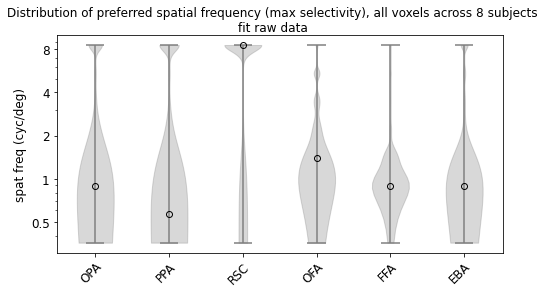

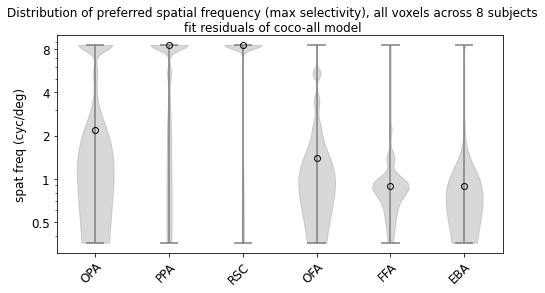

In [13]:

plot_utils.set_all_font_sizes(12)

plt.rcParams['pdf.fonttype']=42

color = '#7f7f7f'

names = ['fit raw data', 'fit residuals of coco-all model']

rois2plot = [6,7,8,9,10,11,]

pi=0
for corrs, name in zip([preferred_sf_corr1, preferred_sf_corr2], names):

    plt.figure(figsize=(8,4))

    for ri, rr in enumerate(rois2plot):

        inds_this_roi = roi_def.get_indices(rr) & abv_thresh

        parts = plt.violinplot(sf_unique[corrs[inds_this_roi].astype(int)],[ri])
        for pc in parts['bodies']:
            pc.set_color(color)
        parts['cbars'].set_color(color)
        parts['cmins'].set_color(color)
        parts['cmaxes'].set_color(color)
        
        plt.plot(ri, np.median(sf_unique[corrs[inds_this_roi].astype(int)]), 'o',\
                color='k', markerfacecolor='none')

        plt.yticks([0,4,8])

        plt.ylabel('spat freq (cyc/deg)')
        plt.gca().set_yscale('log')
        plt.yticks([10**np.log10(0.5), 10**np.log10(1), \
                10**np.log10(2),10**np.log10(4), \
                10**np.log10(8)],\
               [0.5,1,2,4,8])
    
        plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

    plt.xticks(ticks=np.arange(0,len(rois2plot)),\
               labels=np.array(roi_names)[rois2plot],\
               rotation=45, ha='right',rotation_mode='anchor')

    plt.suptitle('Distribution of preferred spatial frequency (max sensitivity), all voxels across 8 subjects\n%s'%name)

    pi+=1
    fn2save = os.path.join(default_paths.fig_path, 'Freq_violins_semresiduals_%d.pdf'%pi)
    plt.savefig(fn2save)

#### Now compute ROI-averaged response profiles
For each participant separately

In [14]:
avg_resp_profiles1 = np.zeros((n_subjects, n_rois, n_ori, n_sf))
avg_resp_profiles2 = np.zeros((n_subjects, n_rois, n_ori, n_sf))

for si in range(n_subjects):
    for ri in range(n_rois):        
        inds_this_roi = roi_def.get_indices(ri) & abv_thresh & (subject_inds==si)   
        avg_resp_profiles1[si,ri,:,:] = np.mean(allcorr_reshaped1[inds_this_roi,:,:], axis=0)
        avg_resp_profiles2[si,ri,:,:] = np.mean(allcorr_reshaped2[inds_this_roi,:,:], axis=0)

#### Plot average orientation sensitivity profiles for some example ROIs

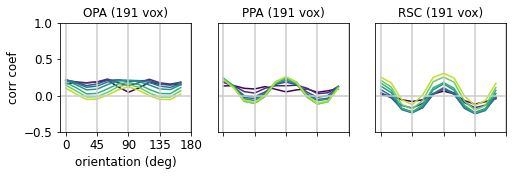

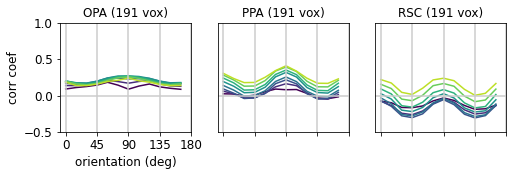

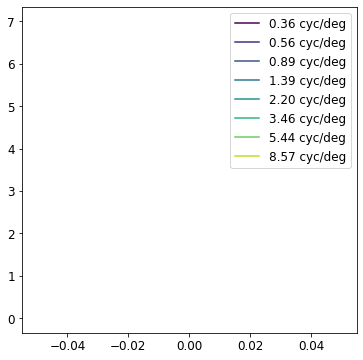

In [15]:
names = ['fit raw data', 'fit residuals of coco-all model']

rois2plot = [6,7,8]

ni=0
plt.rcParams['pdf.fonttype']=42

for corrs, name in zip([avg_resp_profiles1, avg_resp_profiles2], names):


    plt.figure(figsize=(8,2))
    npy = 3
    npx = 1
    
    colors = cm.viridis(np.linspace(0,0.9,n_sf))

    pi=0
    for ri,rr in  enumerate(rois2plot):

        pi+=1
        
        plt.subplot(npx,npy,pi)

        for sf in range(n_sf):
            vals = corrs[:,rr,:,sf]
            meanvals = np.mean(vals , axis=0)
            plt.plot(ori_unique, meanvals,\
                 '-',color=colors[sf,:])
            
        plt.axhline(0, color=[0.8, 0.8, 0.8])
        plt.ylim([-0.5,1])

        if pi==(npx-1)*npy+1:
            plt.xlabel('orientation (deg)')
            plt.ylabel('corr coef')
            plt.xticks(np.arange(0,181,45))
        else:
            plt.xticks(np.arange(0,181,45),labels=[])
            plt.yticks([])

        for ii in np.arange(0,181,45):
            plt.axvline(ii,color=[0.8, 0.8, 0.8])

        plt.title('%s (%d vox)'%(roi_names[rr], np.sum(inds_this_roi)))

    ni+=1
    fn2save = os.path.join(default_paths.fig_path, 'Orient_profiles_sem_residuals_%d.pdf'%ni)
    plt.savefig(fn2save)
    # plt.suptitle('sensitivity profile, averaged within ROIs\n%s'%name)

plt.figure(figsize=(6,6));
for sf in range(n_sf):
    plt.plot(0,sf,color=colors[sf,:])    
plt.legend(['%.2f cyc/deg'%sf_unique[sf] for sf in range(n_sf)]);

#### For all ROIs

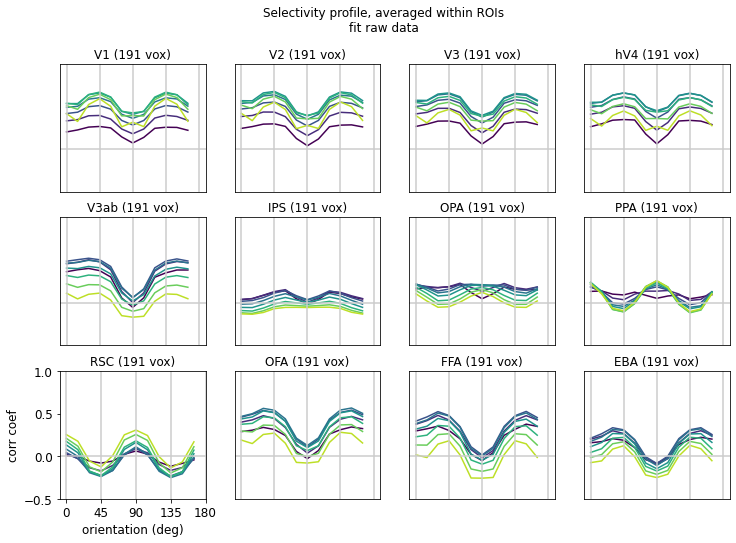

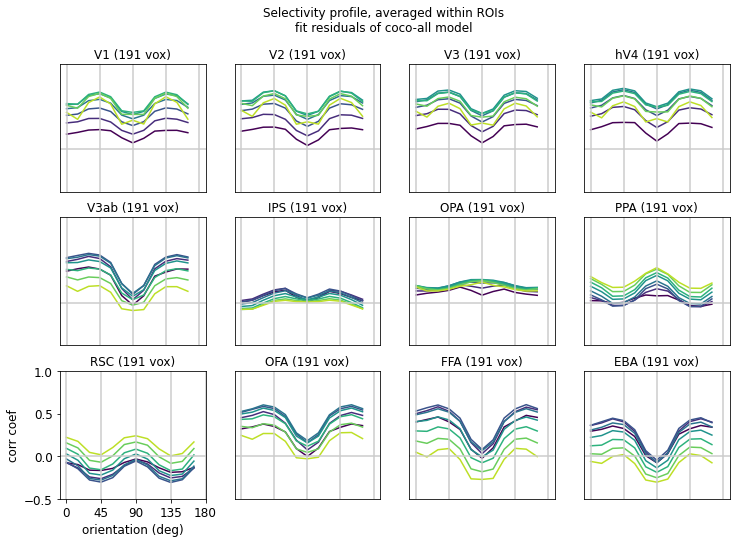

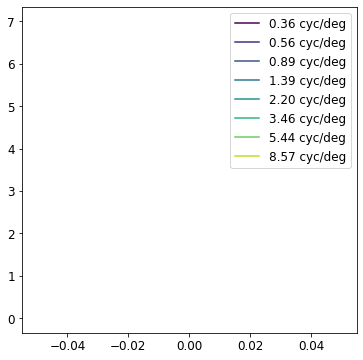

In [16]:
names = ['fit raw data', 'fit residuals of coco-all model']

for corrs, name in zip([avg_resp_profiles1, avg_resp_profiles2], names):


    plt.figure(figsize=(12,8))
    npy = int(np.ceil(np.sqrt(n_rois)))
    npx = int(np.ceil((n_rois)/npy))

    colors = cm.viridis(np.linspace(0,0.9,n_sf))

    pi=0
    for rr in range(n_rois):

        pi+=1
        plt.subplot(npx,npy,pi)

        if np.sum(inds_this_roi)>0:
            for sf in range(n_sf):
                vals = corrs[:,rr,:,sf]
                meanvals = np.mean(vals , axis=0)
                plt.plot(ori_unique, meanvals,\
                     '-',color=colors[sf,:])
           
        plt.axhline(0, color=[0.8, 0.8, 0.8])
        plt.ylim([-0.5,1])

        if pi==(npx-1)*npy+1:
            plt.xlabel('orientation (deg)')
            plt.ylabel('corr coef')
            plt.xticks(np.arange(0,181,45))
        else:
            plt.xticks([]);
            plt.yticks([])

        for ii in np.arange(0,181,45):
            plt.axvline(ii,color=[0.8, 0.8, 0.8])

        plt.title('%s (%d vox)'%(roi_names[rr], np.sum(inds_this_roi)))

    plt.suptitle('sensitivity profile, averaged within ROIs\n%s'%name)

plt.figure(figsize=(6,6));
for sf in range(n_sf):
    plt.plot(0,sf,color=colors[sf,:])    
plt.legend(['%.2f cyc/deg'%sf_unique[sf] for sf in range(n_sf)]);